# Variational Quantum Linear Solver
##### This tutorial aims to implement the Variational Quantum Linear Solver(VQLS) algorithm proposed by [Carlos Bravo-Prieto et al](https://arxiv.org/pdf/1909.05820).

<img src="figures/VQLS_Diagram.png" width="800" height="500" alt="VQLS Diagram">

##### The algorithm takes as input a matrix A written as a linear combination of unitaries A<sub>L</sub> and a short-depth quantum circuit U which prepares the state |b⟩, and produces a quantum state |x⟩ that is approximately proportional to the solution of the linear system Ax= b.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from qibo import (
    Circuit,
    gates,
    set_backend,
)

from qiboml.models.decoding import QuantumDecoding
from qiboml.interfaces.pytorch import QuantumModel

ModuleNotFoundError: No module named 'numpy'

## Define Hyperparameters
##### Setting backend to "pytorch" enables automatic differentiation of quantum circuits using PyTorch. This allows us to use the ADAM optimizer when optimizing the circuit parameters.

In [ ]:
# Set backend
set_backend("qiboml", platform="pytorch")

# Hyper-parameters
n_qubits = 3
q_delta  = 0.001
rng_seed = 42
np.random.seed(rng_seed)
weights = q_delta * np.random.randn(n_qubits)

[Qibo 0.2.18|INFO|2025-06-18 05:11:26]: Using qiboml (pytorch) backend on cpu
INFO:qibo.config:Using qiboml (pytorch) backend on cpu


## Representing our Matrix(A) and Target Vector(b)
##### Matrix A must be represented as a linear combination of unitaries A<sub>L</sub>

In [ ]:
c = np.array([1.0, 0.2, 0.2]) # Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

# Linear combination A = c₀A₀ + c₁A₁ + c₂A₂
A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2

# Target Vector
b = np.ones(8) / np.sqrt(8)

## Initialize Variational Circuit
##### Variational circuit mapping the ground state |0> to the ansatz state |x>.

In [ ]:
def variational_block(weights):
    variational_ansatz = Circuit(n_qubits)
    for idx in range(n_qubits):
        variational_ansatz.add(gates.H(idx))
    for idx, element in enumerate(weights):
        variational_ansatz.add(gates.RY(idx,element))
    return variational_ansatz

## Building Custom Decoder
##### The parameters should be optimized in order to maximize the overlap between the quantum states $|\Psi\rangle$ and $|b\rangle$

$$
C_G = 1 - |\langle b | \Psi \rangle|^2
$$

##### Using the QuantumDecoding class from the QiboML library we are able to generate our desired cost from the output of our variational circuit. Ensure all tensor operations within the decoder use torch operations to maintain compatibility with PyTorch autograd.

In [ ]:
class CustomDecoder(QuantumDecoding):
    def __init__(self, nqubits: int, target_state: np.ndarray, A: np.ndarray):
        super().__init__(nqubits)
        # Wrap target_state as a complex tensor to match Qiboml’s default dtype
        self.target_state = torch.tensor(
            target_state,
            dtype=torch.complex128
        )
        self.A = torch.tensor(
            A,
            dtype=torch.complex128
        )

    def __call__(self, circuit: Circuit) -> torch.Tensor:
        result = super().__call__(circuit)
        state = result.state()
        final_state = (self.A @ state)
        normalized_state = final_state / torch.linalg.norm(final_state)
        overlap = torch.vdot(self.target_state, normalized_state)
        return 1 - overlap.abs()**2

## Build Model
##### Use QiboML's QuantumModel class to build the machine learning model.

In [ ]:
# Prepare the test circuit and decoder
circuit = variational_block(weights)
decoder = CustomDecoder(n_qubits, target_state=b, A = A_num)

# Build Model
model = QuantumModel(
    decoding=decoder,
    circuit_structure=circuit)

## Train Circuit
##### Use the ADAM optimizer to perform gradient descent on loss landscape and optimize circuit parameters.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Optimize
for iteration in range(300):
    optimizer.zero_grad()
    cost = model()
    cost.backward()
    optimizer.step()

    if iteration % 20 == 0:
        print(f"Iteration {iteration}: Cost = {cost.item():.6f}")

Iteration 0: Cost = 0.027048
Iteration 20: Cost = 0.000190
Iteration 40: Cost = 0.000196
Iteration 60: Cost = 0.000003
Iteration 80: Cost = 0.000004
Iteration 100: Cost = 0.000001
Iteration 120: Cost = 0.000000
Iteration 140: Cost = 0.000000
Iteration 160: Cost = 0.000000
Iteration 180: Cost = 0.000000
Iteration 200: Cost = 0.000000
Iteration 220: Cost = 0.000000
Iteration 240: Cost = 0.000000
Iteration 260: Cost = 0.000000
Iteration 280: Cost = 0.000000


## Final Parameters and Results

In [ ]:
optimized_params = model.circuit_parameters.detach().cpu().numpy()
print("Optimized theta values: ", optimized_params)
param_circuit = variational_block(optimized_params)
result = param_circuit.execute()
final_state = result.state().detach().numpy()
print("Final state vector (as amplitudes):")
print(final_state)

Optimized theta values:  [-5.42217340e-09  3.30297394e-01 -8.53152145e-09]
Final state vector (as amplitudes):
[0.29061909+0.j 0.29061909+0.j 0.40686674+0.j 0.40686674+0.j
 0.29061909+0.j 0.29061909+0.j 0.40686674+0.j 0.40686674+0.j]


## Comparison with Classical Solution

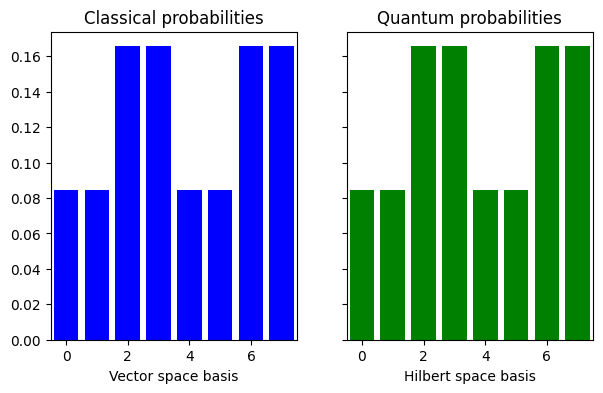

In [ ]:
q_probs = np.abs(final_state)**2

A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()